In [25]:
import keras
from keras import layers
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import layers, models, activations, optimizers, callbacks, metrics, Input

In [26]:
# function to calculate the smallest power of 2 equal to or greater than the input
def smallest_power_of_2(n):
    n -= 1  # Subtract 1 to ensure we handle powers of 2 correctly
    n |= n >> 1
    n |= n >> 2
    n |= n >> 4
    n |= n >> 8
    n |= n >> 16
    n += 1
    return n

In [27]:
def pad_to_next_power_of_2(matrix):
    # Calculate the new dimensions for height and width
    new_height = smallest_power_of_2(matrix.shape[0])
    new_width = smallest_power_of_2(matrix.shape[1])
    #new_width = smallest_power_of_2(matrix.shape[1])

    # Calculate the padding values
    vertical_pad = new_height - matrix.shape[0]
    horizontal_pad = new_width - matrix.shape[1]

    # Create a new matrix with the desired dimensions and pad the original matrix
    padded_matrix = np.pad(matrix, ((0, vertical_pad), (0, horizontal_pad)), mode='constant')

    return padded_matrix

In [28]:
def remove_padding(matrix, original_shape):
    if matrix.shape == original_shape:
        return matrix  # No padding to remove

    # remove padding from right and bottom
    h_orig, w_orig = original_shape
    h_padded, w_padded = matrix.shape

    if h_padded < h_orig or w_padded < w_orig:
        raise ValueError("Original shape is larger than the padded shape.")

    else :
         cropped_matrix = matrix[0:h_orig, 0:w_orig]
   
    return cropped_matrix

In [29]:
def ImagePreprocessing(image):
    # Convert the image to RGB (if it's in BGR format)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Convert the image to a NumPy array
    img_array = np.array(img_rgb)

    # normalize image from 0 to 1
    img_normalized = img_rgb.astype('float32')/255.0
    
    RChannel = img_normalized[:,:,0]
    GChannel = img_normalized[:,:,1]
    BChannel = img_normalized[:,:,2]
    
    # Padding the image to a power of 2**
    R_power2_padded = pad_to_next_power_of_2(RChannel)
    G_power2_padded = pad_to_next_power_of_2(GChannel)
    B_power2_padded = pad_to_next_power_of_2(BChannel)
    
    h_new = R_power2_padded.shape[0]
    w_new = R_power2_padded.shape[1]

    RChannel_processed = np.reshape(R_power2_padded, (1, h_new, w_new, 1))
    GChannel_processed = np.reshape(G_power2_padded, (1, h_new, w_new, 1))
    BChannel_processed = np.reshape(B_power2_padded, (1, h_new, w_new, 1))
    
    
    image_RGB_matrix_processed = [RChannel_processed, GChannel_processed, BChannel_processed, h_new, w_new]

    return image_RGB_matrix_processed

In [30]:
def ChannelAnalysis(channel):
    print("Maximum value : ", np.max(channel))
    print("Minimum value : ",np.min(channel))
    # Flatten the matrix to 1D array
    values = channel.flatten()

    # Plot histogram
    plt.hist(values, bins=100, density=False, alpha=0.75, color='b')
    plt.title('Distribution of Values in the Matrix')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()
    
    # Plot heatmap
    plt.imshow(channel, cmap='viridis', interpolation='nearest')
    plt.colorbar()  # Add colorbar to show the mapping of values to colors
    plt.title('Heatmap of Channel Values')
    plt.show()
    
    return 1

def ChannelImageExtraction(image, channel):
    # Convert the image to RGB (if it's in BGR format)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Convert the image to a NumPy array
    img_array = np.array(img_rgb)
    (height, width, channels) = img.shape
    
    ChannelPadding = np.zeros((height,width))
    
    if channel=='R':
        print("Channel Analysis : Original Red Channel")
        ChannelAnalysis(img_array[:,:,0])
        img_array[:,:,1] = ChannelPadding
        img_array[:,:,2] = ChannelPadding
    if channel=='G':
        print("Channel Analysis : Original Green Channel")
        ChannelAnalysis(img_array[:,:,1])
        img_array[:,:,0] = ChannelPadding
        img_array[:,:,2] = ChannelPadding
    if channel=='B':
        print("Channel Analysis : Original Blue Channel")
        ChannelAnalysis(img_array[:,:,2])
        img_array[:,:,0] = ChannelPadding
        img_array[:,:,1] = ChannelPadding
    
    return img_array

In [31]:
postflattenlength = 0   # length after flatten
preflattenshape = (0,0,0)  # dimension before preflatten

In [32]:
class CNNHAE_Encoder:
    def __init__(self, h, w):
        self.h = h
        self.w = w
        self.input = 0
        
        # define hyperparameters
        self.act = 'relu'  # activation function used in the convolution layers
        self.fs = (3, 3)  # filter size for the convolutional kernels
        self.ffs = (2, 2)  # filter size for max pooling
        self.st = (1, 1)  # strides for the convolution operation
        
        self.encoder = self.build_encoder()
        
    def build_encoder(self):
        # initialize the input layer with the shape of the data
        input_img = Input(shape=(self.h, self.w, 1))
        self.input = input_img
        
        global preflattenshape
        global postflattenlength

        # ENCODER
        # convolutional Layer with 64 kernels. padding is 'same' and activation function is ReLU.
        x = layers.Conv2D(8, self.fs, activation=self.act, strides=self.st, padding="same")(input_img)
        # max Pooling Layer to reduce dimensions
        x = layers.MaxPooling2D(self.ffs, padding="same")(x)

        # fourth Convolutional Layer with 256 kernels
        x = layers.Conv2D(32, self.fs, activation=self.act, strides=self.st, padding='same')(x)
        # fourth Max Pooling Layer
        x = layers.MaxPooling2D(self.ffs, padding='same')(x)

        preflattenshape = (x.shape[1], x.shape[2], x.shape[3])
        
        # flatten the output of the last Max Pooling Layer
        x = layers.Flatten()(x)
        postflattenlength = x.shape[1]
        
        # fully connected layer with 128 units and ReLU activation
        x = layers.Dense(128, activation=self.act)(x)
        
        # latent layer with 'd' dimensions
        encoded_img = layers.Dense(d)(x)
        
        encoder = models.Model(input_img, encoded_img)
        return encoder
    
    def encode(self,data):
        encoded_data = self.encoder.layers[0](data)
        encoded_data = self.encoder.layers[1](encoded_data)
        encoded_data = self.encoder.layers[2](encoded_data)
        encoded_data = self.encoder.layers[3](encoded_data)
        encoded_data = self.encoder.layers[4](encoded_data)
        encoded_data = self.encoder.layers[5](encoded_data)
        encoded_data = self.encoder.layers[6](encoded_data)
        encoded_data = self.encoder.layers[7](encoded_data)
        return encoded_data
    
    def summary(self):
        self.encoder.summary()

In [33]:
class CNNHAE_Decoder:
    def __init__(self, h, w, instanceNum):
        self.h = h
        self.w = w
        self.heirarchyNum = instanceNum + 1
        
        # define hyperparameters
        self.act = 'relu'  # activation function used in the convolution layers
        self.fs = (3, 3)  # filter size for the convolutional kernels
        self.ffs = (2, 2)  # filter size for max pooling
        self.st = (1, 1)  # strides for the convolution operation
        
        self.decoder = self.build_decoder()
        
    def build_decoder(self):
        # with decorder, you go into the opposite direction
        code_d = layers.Input(shape = (1,self.heirarchyNum*d))
        
        global postflattenlength
        global preflattenshape
        
        x = layers.Dense(128, activation=self.act)(code_d)
        x = layers.Dense(postflattenlength, activation = self.act)(x)
        x = layers.Reshape(preflattenshape)(x)
        
        x = layers.UpSampling2D(self.ffs)(x)
        x = layers.Conv2D(32, self.fs, activation = self.act, strides = self.st, padding='same')(x)
        
        x = layers.UpSampling2D(self.ffs)(x)
        x = layers.Conv2D(8, self.fs, activation = self.act, strides = self.st, padding='same')(x)
        
        decoded_img = layers.Conv2D(1, self.fs, activation = 'sigmoid', strides = self.st, padding='same')(x)
        
        decoder = models.Model(code_d, decoded_img)
        return decoder
    
    def decode(self, encoded_data):
        decoded_data = self.decoder.layers[0](encoded_data)
        decoded_data = self.decoder.layers[1](decoded_data)
        decoded_data = self.decoder.layers[2](decoded_data)
        decoded_data = self.decoder.layers[3](decoded_data)
        decoded_data = self.decoder.layers[4](decoded_data)
        decoded_data = self.decoder.layers[5](decoded_data)
        decoded_data = self.decoder.layers[6](decoded_data)
        decoded_data = self.decoder.layers[7](decoded_data)
        decoded_data = self.decoder.layers[8](decoded_data)
        return decoded_data
    
    def summary(self):
        self.decoder.summary()


In [34]:
img = cv2.imread('/kaggle/input/sm2001-project-q4-dataset/KTH_photo reduced 5.jpg')
(orig_h, orig_w, channels) = img.shape

[RChannel, GChannel, BChannel, h, w] = ImagePreprocessing(img)

In [35]:
# Create an instance of the Autoencoder class
d = 3  # size of the reduced vector in the latent layer
N = 1  # size of hierarchy


Encoder_instances_R = []  # Create an empty list to store instances
Decoder_instances_R = []  # Create an empty list to store instances

for i in range(N):
    instance_en = CNNHAE_Encoder(h, w)  # Create an instance of the class
    Encoder_instances_R.append(instance_en)  # Add the instance to the list
    instance_de = CNNHAE_Decoder(h, w, i)  # Create an instance of the class
    Decoder_instances_R.append(instance_de)  # Add the instance to the list


Encoder_instances_G = []  # Create an empty list to store instances
Decoder_instances_G = []  # Create an empty list to store instances

for i in range(N):
    instance_en = CNNHAE_Encoder(h, w)  # Create an instance of the class
    Encoder_instances_G.append(instance_en)  # Add the instance to the list
    instance_de = CNNHAE_Decoder(h, w, i)  # Create an instance of the class
    Decoder_instances_G.append(instance_de)  # Add the instance to the list


Encoder_instances_B = []  # Create an empty list to store instances
Decoder_instances_B = []  # Create an empty list to store instances

for i in range(N):
    instance_en = CNNHAE_Encoder(h, w)  # Create an instance of the class
    Encoder_instances_B.append(instance_en)  # Add the instance to the list
    instance_de = CNNHAE_Decoder(h, w, i)  # Create an instance of the class
    Decoder_instances_B.append(instance_de)  # Add the instance to the list

In [36]:
num_epochs = 10

# Train the Red Channel Convolution AE
print("Training the Red Channel Convolution AutoEncoder")

set_of_latent_vectors_R = []

for i in range(N):
    ip = Encoder_instances_R[i].encoder.input
    encoded_instance = Encoder_instances_R[i].encode(ip)

    for latentVector in set_of_latent_vectors_R:
         encoded_instance = tf.concat([encoded_instance, latentVector], axis=1)
    
    op = Decoder_instances_R[i].decode(encoded_instance)
    model = models.Model(ip, op)
    model.compile(optimizer='adam', loss='mse')

    progress = tqdm(range(num_epochs))
    for epoch in progress:
         model.fit(RChannel, RChannel, epochs = 1, verbose = 0)
    
    latentVector_R = Encoder_instances_R[i].encode(RChannel)
    set_of_latent_vectors_R.append(latentVector_R)
    
    

# Train the Green Channel Convolution AE
print("Training the Green Channel Convolution AutoEncoder")

set_of_latent_vectors_G = []

for i in range(N):
    ip = Encoder_instances_G[i].encoder.input
    encoded_instance = Encoder_instances_G[i].encode(ip)

    for latentVector in set_of_latent_vectors_G:
         encoded_instance = tf.concat([encoded_instance, latentVector], axis=1)
    
    op = Decoder_instances_G[i].decode(encoded_instance)
    model = models.Model(ip, op)
    model.compile(optimizer='adam', loss='mse')

    progress = tqdm(range(num_epochs))
    for epoch in progress:
         model.fit(GChannel, GChannel, epochs = 1, verbose = 0)
            
    latentVector_G = Encoder_instances_G[i].encode(GChannel)
    set_of_latent_vectors_G.append(latentVector_G)
    
     

# Train the Blue Channel Convolution AE
print("Training the Blue Channel Convolution AutoEncoder")
    
set_of_latent_vectors_B = []

for i in range(N):
    ip = Encoder_instances_B[i].encoder.input
    encoded_instance = Encoder_instances_B[i].encode(ip)

    for latentVector in set_of_latent_vectors_B:
         encoded_instance = tf.concat([encoded_instance, latentVector], axis=1)
    
    op = Decoder_instances_B[i].decode(encoded_instance)
    model = models.Model(ip, op)
    model.compile(optimizer='adam', loss='mse')

    progress = tqdm(range(num_epochs))
    for epoch in progress:
         model.fit(BChannel, BChannel, epochs = 1, verbose = 0)
    
    latentVector_B = Encoder_instances_B[i].encode(BChannel)
    set_of_latent_vectors_B.append(latentVector_B)


Training the Red Channel Convolution AutoEncoder


100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


Training the Green Channel Convolution AutoEncoder


100%|██████████| 10/10 [00:23<00:00,  2.34s/it]


Training the Blue Channel Convolution AutoEncoder


100%|██████████| 10/10 [00:23<00:00,  2.37s/it]


In [37]:
finalLatentVector_R = tf.reshape(set_of_latent_vectors_R, (1,d*N))
reconstructedChannel_R = Decoder_instances_R[N-1].decode(finalLatentVector_R)

finalLatentVector_G = tf.reshape(set_of_latent_vectors_G, (1,d*N))
reconstructedChannel_G = Decoder_instances_G[N-1].decode(finalLatentVector_G)

finalLatentVector_B = tf.reshape(set_of_latent_vectors_B, (1,d*N))
reconstructedChannel_B = Decoder_instances_B[N-1].decode(finalLatentVector_B)

[[[[5.10646999e-01]
   [5.45521140e-01]
   [6.46752894e-01]
   ...
   [1.01163205e-05]
   [7.85732293e-04]
   [1.40120769e-02]]

  [[5.30980349e-01]
   [6.12158477e-01]
   [6.87542439e-01]
   ...
   [7.29805993e-10]
   [7.81193023e-07]
   [8.48861309e-05]]

  [[6.54522121e-01]
   [7.51642108e-01]
   [8.01469266e-01]
   ...
   [1.02933231e-10]
   [3.49467868e-08]
   [1.95116650e-06]]

  ...

  [[3.68913228e-04]
   [6.80575241e-08]
   [6.97050195e-10]
   ...
   [1.73408905e-14]
   [1.84170734e-11]
   [1.18155583e-07]]

  [[1.04754902e-02]
   [6.26564361e-06]
   [6.16591294e-08]
   ...
   [2.25054655e-10]
   [7.31212246e-09]
   [7.44572731e-07]]

  [[2.82263104e-02]
   [2.38541703e-04]
   [8.92756452e-06]
   ...
   [3.17806581e-07]
   [5.76282787e-07]
   [8.31975995e-05]]]]


285
381
Original Red Channel
Channel Analysis : Original Red Channel
Maximum value :  255
Minimum value :  0


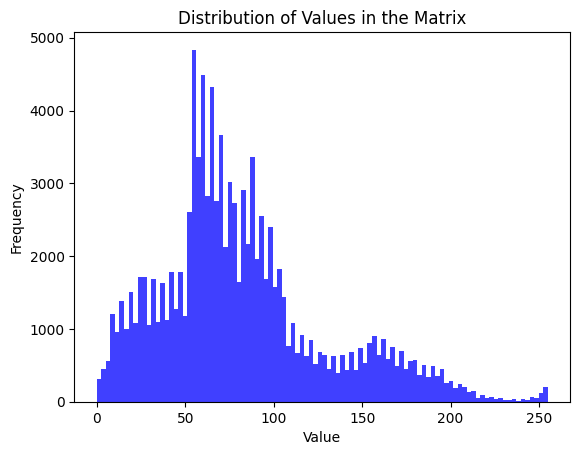

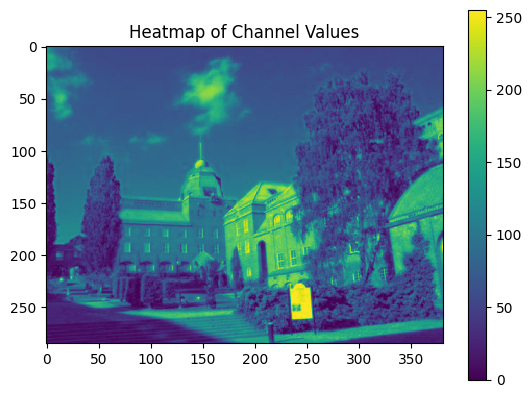

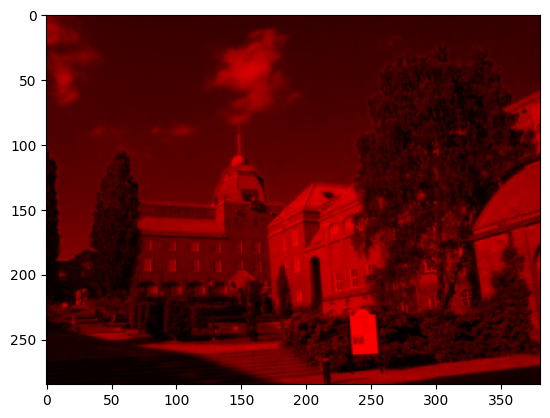

Reconstructed Red Channel
Maximum value :  254.99036
Minimum value :  6.4299334e-18


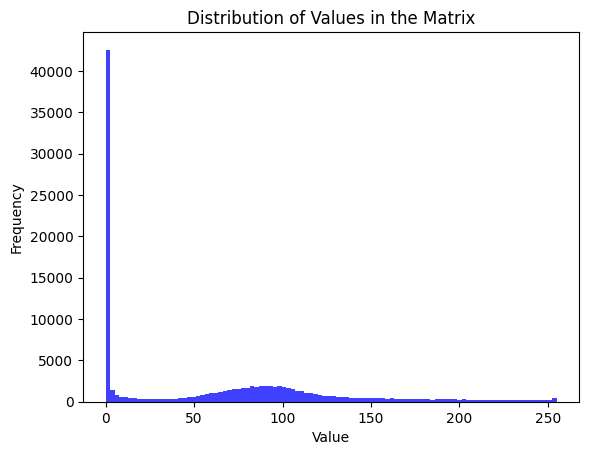

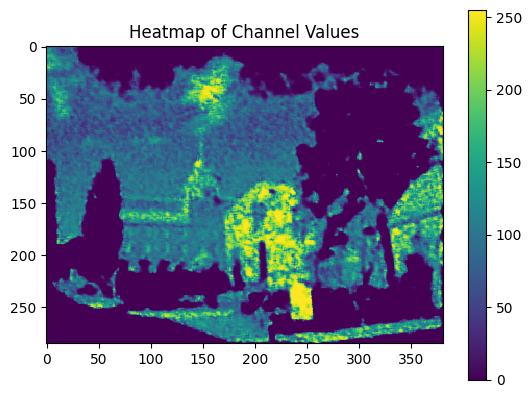

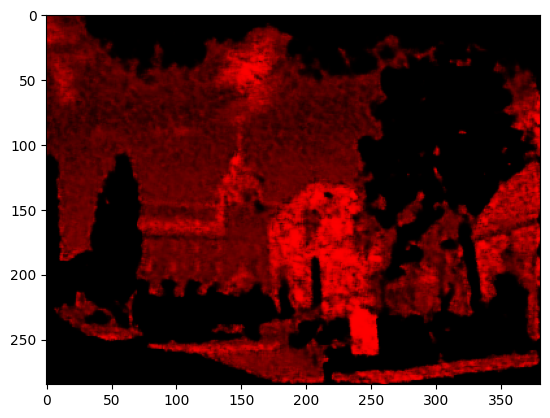

Original Green Channel
Channel Analysis : Original Green Channel
Maximum value :  255
Minimum value :  0


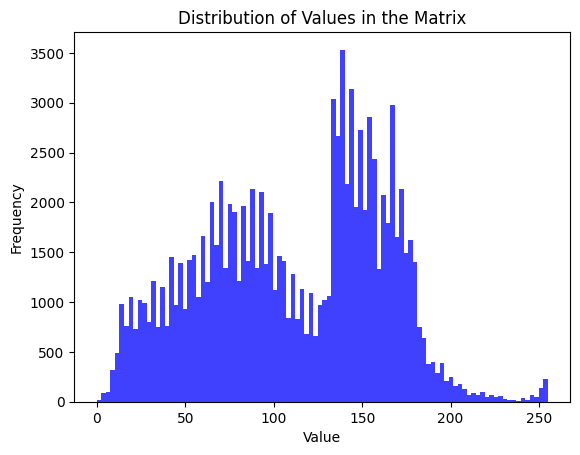

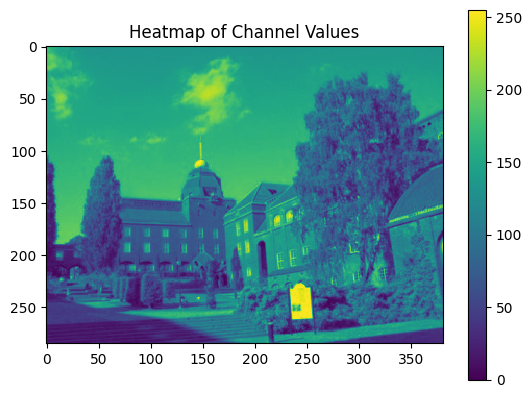

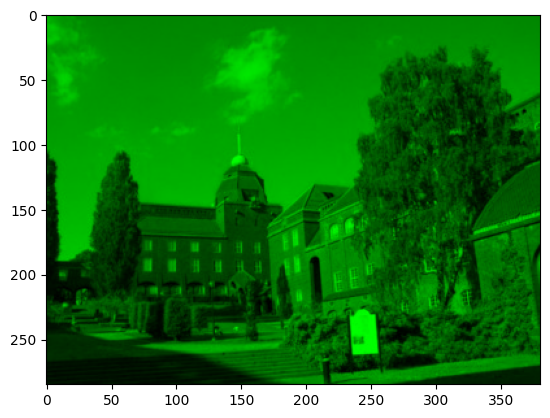

Reconstructed Green Channel
Maximum value :  253.20457
Minimum value :  2.4765348e-15


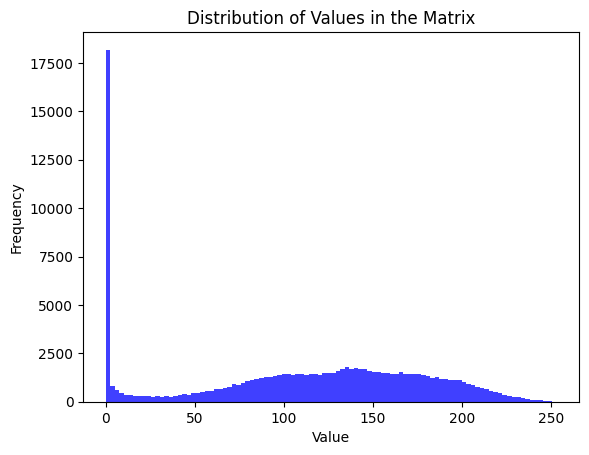

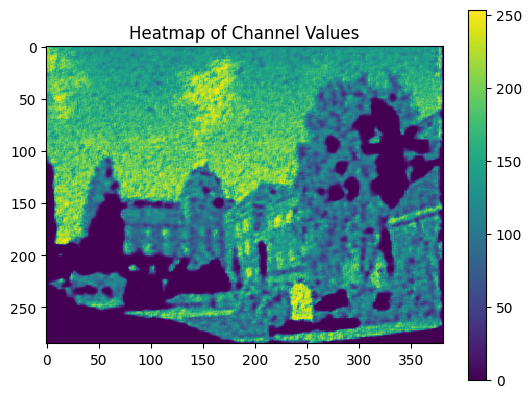

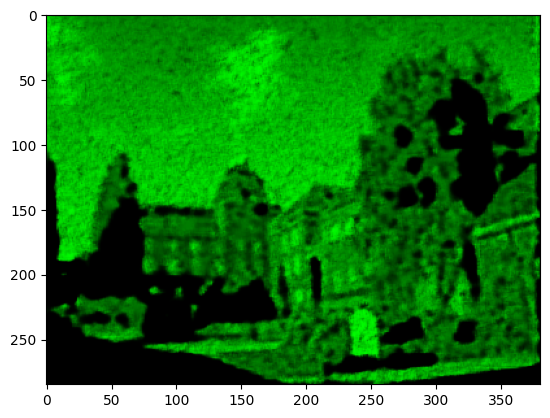

Original Blue Channel
Channel Analysis : Original Blue Channel
Maximum value :  255
Minimum value :  0


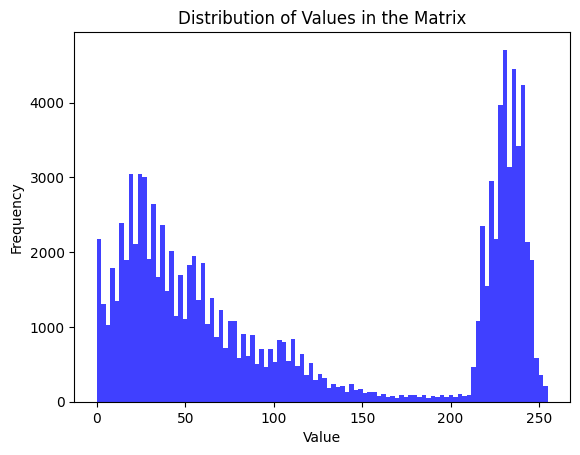

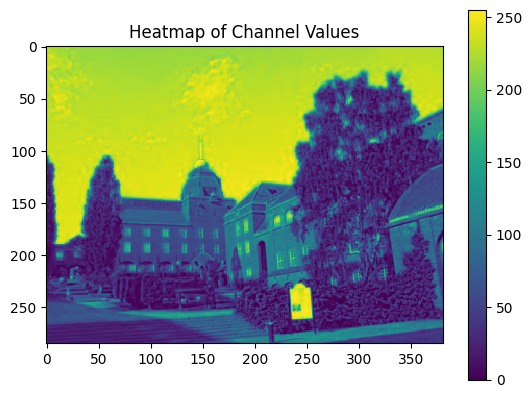

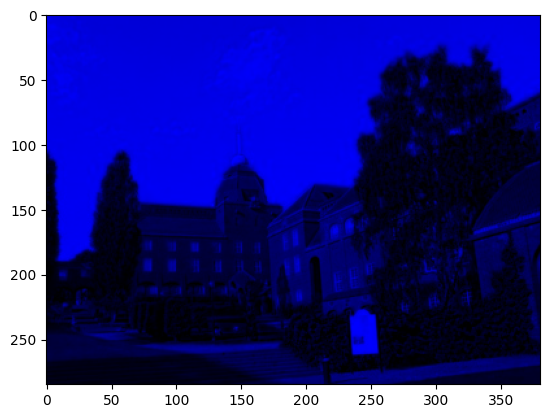

Reconstructed Blue Channel
Maximum value :  254.50066
Minimum value :  1.2217472e-17


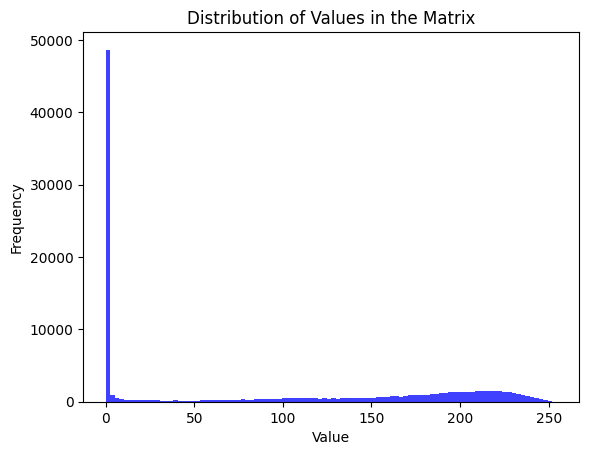

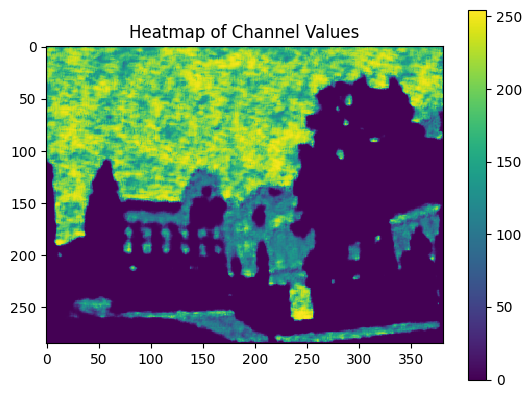

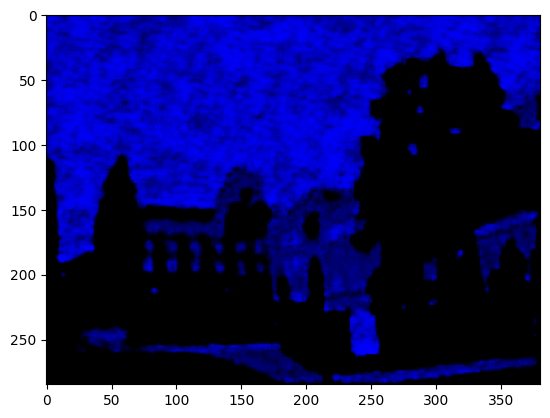

In [40]:
ChannelPadding = np.zeros((orig_h,orig_w))
print(orig_h)
print(orig_w)

# Red Channel
print("Original Red Channel")
Original_RChannel_Image = ChannelImageExtraction(img,'R') # includes analysis
plt.imshow(Original_RChannel_Image)
plt.show()

print("Reconstructed Red Channel")
reconstructedChannel_R = np.squeeze(reconstructedChannel_R)
RChannel_unpadded = remove_padding(reconstructedChannel_R, (orig_h,orig_w))
RChannelLayer_Reconstructed = RChannel_unpadded*255
ChannelAnalysis(RChannelLayer_Reconstructed)
reconstructed_RChannel_Image = np.dstack((RChannelLayer_Reconstructed, ChannelPadding, ChannelPadding))
plt.imshow(reconstructed_RChannel_Image.astype('uint8')) # .astype('unint8') !!!!
plt.show()

# Green Channel
print("Original Green Channel")
Original_GChannel_Image = ChannelImageExtraction(img,'G') # includes analysis
plt.imshow(Original_GChannel_Image)
plt.show()

print("Reconstructed Green Channel")
reconstructedChannel_G = np.squeeze(reconstructedChannel_G)
GChannel_unpadded = remove_padding(reconstructedChannel_G, (orig_h,orig_w))
GChannelLayer_Reconstructed = GChannel_unpadded*255
ChannelAnalysis(GChannelLayer_Reconstructed)
reconstructed_GChannel_Image = np.dstack((ChannelPadding, GChannelLayer_Reconstructed, ChannelPadding))
plt.imshow(reconstructed_GChannel_Image.astype('uint8')) # .astype('unint8') !!!!
plt.show()


# Blue Channel
print("Original Blue Channel")
Original_BChannel_Image = ChannelImageExtraction(img,'B') # includes analysis
plt.imshow(Original_BChannel_Image)
plt.show()

print("Reconstructed Blue Channel")
reconstructedChannel_B = np.squeeze(reconstructedChannel_B)
BChannel_unpadded = remove_padding(reconstructedChannel_B, (orig_h,orig_w))
BChannelLayer_Reconstructed = BChannel_unpadded*255
ChannelAnalysis(BChannelLayer_Reconstructed)
reconstructed_BChannel_Image = np.dstack((ChannelPadding, ChannelPadding, BChannelLayer_Reconstructed))
plt.imshow(reconstructed_BChannel_Image.astype('uint8')) # .astype('unint8') !!!!
plt.show()


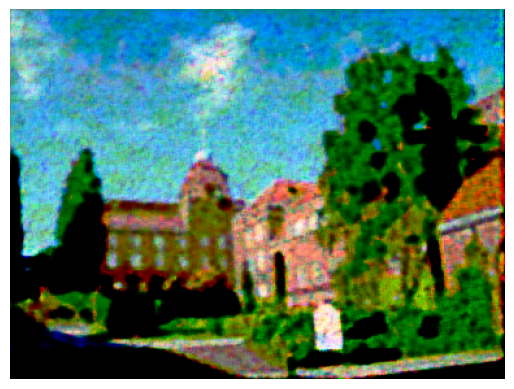

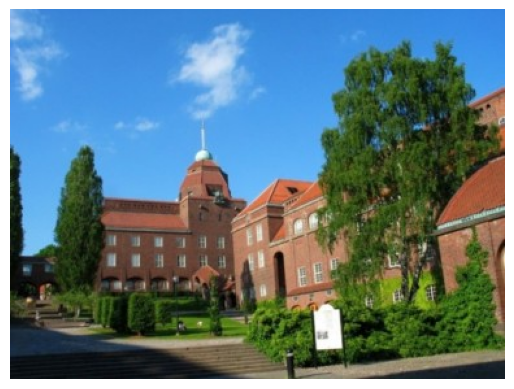

In [41]:
# Recombine the channels into one RGB matrix
reconstructed_rgb_image = np.dstack((RChannelLayer_Reconstructed, GChannelLayer_Reconstructed, BChannelLayer_Reconstructed))

# Display the recombined image
plt.imshow(reconstructed_rgb_image.astype('uint8'))
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

# Display original image to compare
plt.imshow(np.array(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)).astype('uint8'))
plt.axis('off')  # Turn off axis labels and ticks
plt.show()